In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random

import pickle

from sklearn import preprocessing

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

%matplotlib inline


from scipy.stats import ks_2samp

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import roc_auc_score

import eli5
from eli5.sklearn import PermutationImportance

import shap



/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from importlib import reload
import logging

# ## activate logging ##
# reload(logging)
# logger = logging.getLogger()

## deactivate logger ##
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

Import created modules

In [3]:
from src.helpers import *
from src.read_data import *

from src.cleaner import clean_data

from src.feature_selection import *

In [4]:
SEED = 0

# Load data

## Load sampled data

In [5]:
%%time

azdias = read_data('Udacity_AZDIAS_052018.csv', n_skiprows = 5)
customers = read_data('Udacity_CUSTOMERS_052018.csv', n_skiprows = 3)

Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.


Reducing memory usage...
Mem. usage decreased to 115.42 Mb (76.8% reduction)

Completed. Shape of the data:  (178244, 366)
Reducing memory usage...
Mem. usage decreased to 42.40 Mb (76.4% reduction)

Completed. Shape of the data:  (63884, 369)
CPU times: user 28.6 s, sys: 15.8 s, total: 44.3 s
Wall time: 45.1 s


## Load original data

In [6]:
%%time 

azdias_full = read_data('Udacity_AZDIAS_052018.csv', reduce_memory = False)
customers_full = read_data('Udacity_CUSTOMERS_052018.csv', reduce_memory = False)


Completed. Shape of the data:  (891221, 366)

Completed. Shape of the data:  (191652, 369)
CPU times: user 22.5 s, sys: 4.13 s, total: 26.6 s
Wall time: 27 s


## Comparison between sampled and original

### Visual inspection

Variable: KBA13_BJ_2004


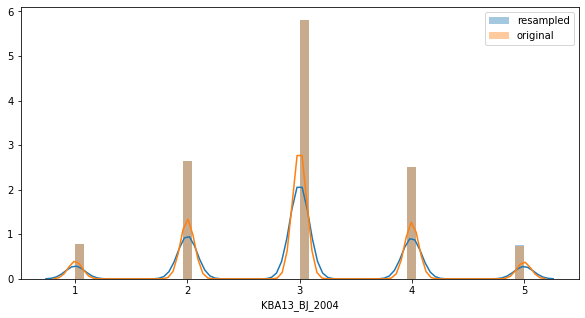


Variable: KBA13_FAB_ASIEN


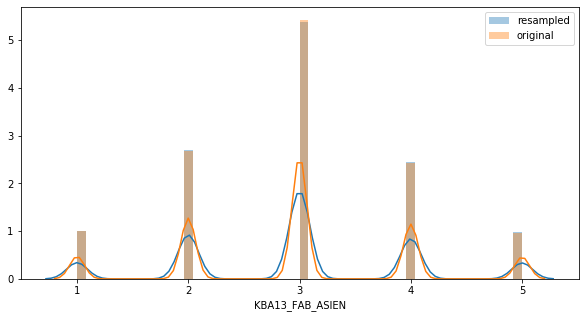


Variable: CJT_KATALOGNUTZER


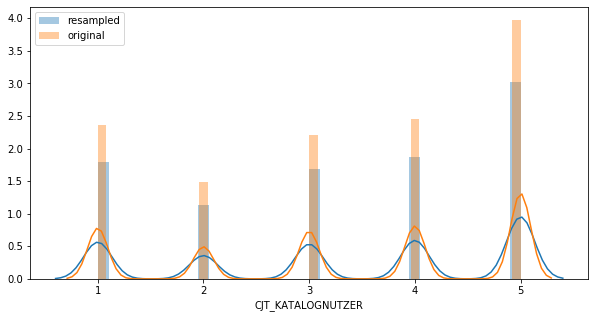


Variable: KBA05_CCM4


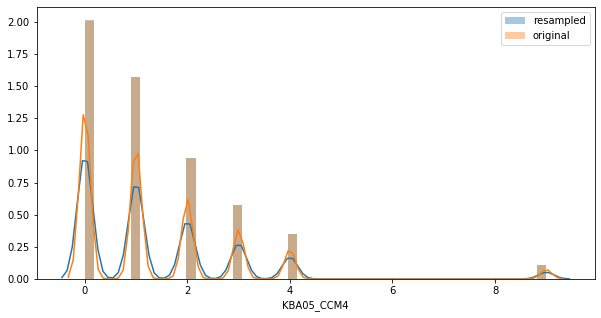


Variable: KBA13_KW_50


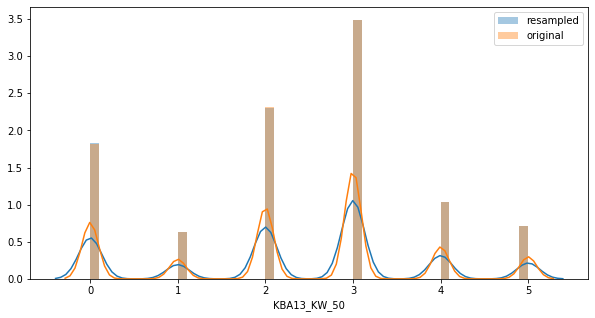

In [7]:
random.seed(SEED)
for i in random.sample(range(1, 366), 5):
    plt.figure(figsize = (10,5))
    variable = azdias.columns[i]
    print(f'Variable: {variable}')
    
    sns.distplot(azdias.iloc[:, i], label = 'resampled')
    sns.distplot(azdias_full.iloc[:,i], label = 'original')
    plt.legend()
    plt.show()
    print()

### KS test

KS test to compare two samples

In [8]:
numerical_columns, categorical_columns = var_lists(azdias)

In [9]:
for i in random.sample(range(1, 366), 10):
    variable = azdias.columns[i]
    
    p_val = ks_2samp(azdias.iloc[:, i], azdias_full.iloc[:,i]).pvalue
    print(f'Variable: {variable}; p-value: {p_val} ')
    print()

Variable: KBA13_KRSHERST_AUDI_VW; p-value: 0.6735909028777959 

Variable: KBA13_CCM_1500; p-value: 0.9845215421424507 

Variable: KBA05_MAXHERST; p-value: 0.8815667964800717 

Variable: KBA13_KMH_211; p-value: 0.9985040385071067 

Variable: KBA13_ALTERHALTER_30; p-value: 0.7006536766474607 

Variable: KBA13_VW; p-value: 0.567734071110832 

Variable: GEMEINDETYP; p-value: 0.9999999999864381 

Variable: KBA13_KW_121; p-value: 0.9995167095140515 

Variable: D19_TELKO_ANZ_24; p-value: 1.0 

Variable: KBA05_KRSHERST2; p-value: 0.9999923203096179 



In [10]:
for variable in numerical_columns:
    
    n_vars = 0
    p_val = ks_2samp(azdias.loc[:, variable], azdias_full.loc[:,variable]).pvalue
    try: 
        if (p_val.tolist()) < 0.05: 
            print(f'Variable: {variable}; p-value: {p_val} ')
            n_vars += 1
            
    except:
        print(f'\tSth wrong for {variable}')
        
print(f'Number of variables with different distributions in original vs resampled: {n_vars}')

Number of variables with different distributions in original vs resampled: 0


For all variables the 2-sampled KS test suggests that both distributions are similar.

## Data cleaning


In [11]:
%%time

azdias_clean = clean_data(azdias)
azdias_clean.shape

Initial df shape: (178244, 365)
Variables with missing values...
Your selected dataframe has 365 columns.
There are 273 columns that have missing values.
	Dropped 6 variables
Highly correlated variables...
	Dropped 63 variables
Constant variables
	Dropped 0 variables
Final df shape: (178244, 297)
CPU times: user 51.1 s, sys: 1.29 s, total: 52.4 s
Wall time: 52.9 s


(178244, 296)

In [12]:
%%time

customers_clean = clean_data(customers)
customers_clean.shape

Initial df shape: (63884, 368)
Variables with missing values...
Your selected dataframe has 368 columns.
There are 273 columns that have missing values.
	Dropped 5 variables
Highly correlated variables...
	Dropped 66 variables
Constant variables
	Dropped 0 variables
Final df shape: (63884, 301)
CPU times: user 21 s, sys: 465 ms, total: 21.4 s
Wall time: 21.5 s


(63884, 300)

In [13]:
final_vars = list(set(customers_clean.columns).intersection(set(azdias_clean.columns)))
len(final_vars)

285

In [14]:
customers_clean = customers_clean[final_vars]
azdias_clean = azdias_clean[final_vars]

azdias_clean.shape, customers_clean.shape

((178244, 285), (63884, 285))

# Dimensionality reduction

## Random Forest feature importance

-----

Let's train a RF classifier to detect which features are more important to that model


In [15]:
customer_f = customers_clean.copy()
azdias_f = azdias_clean.copy()
print(customer_f.shape, azdias_f.shape)

customer_f['Target'] = 1
azdias_f['Target'] = 0

both = pd.concat([azdias_f, customer_f], axis = 0)
both_resampled = both.sample(30000, random_state = SEED)
both.shape, both_resampled.shape

(63884, 285) (178244, 285)


((242128, 286), (30000, 286))

In [16]:
%%time

top_n = 20

X_train, X_test, y_train, y_test = split(both)

numerical_columns, categorical_columns = var_lists(both)

rf = create_pipe(categorical_columns, numerical_columns)

rf.fit(X_train, y_train)

CPU times: user 1min 35s, sys: 1.65 s, total: 1min 36s
Wall time: 1min 37s


Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [17]:
feature_names = get_feats(rf, categorical_columns, numerical_columns)

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)


In [18]:
rf_importances_df = pd.DataFrame({'features': feature_names,
                     'importances': tree_feature_importances})\
                .sort_values('importances',ascending = False)\
                .reset_index(drop=True)
rf_importances_df[:top_n]

,features,importances
0,D19_SOZIALES,0.106450
1,D19_KONSUMTYP,0.049422
2,ALTERSKATEGORIE_GROB,0.026368
3,CJT_TYP_6,0.022527
4,CJT_TYP_3,0.019045
5,CJT_TYP_5,0.018447
6,AKT_DAT_KL,0.017410
7,ALTERSKATEGORIE_FEIN,0.016826
8,RT_SCHNAEPPCHEN,0.015170
9,EINGEZOGENAM_HH_JAHR,0.014039


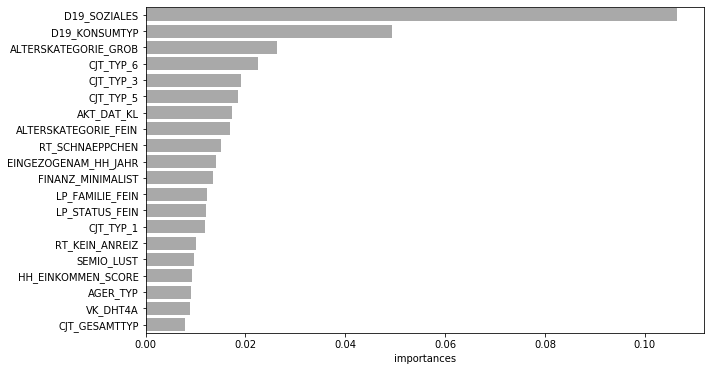

In [19]:
plt.subplots(figsize=(10,6))
sns.barplot(data = rf_importances_df[:top_n], x = 'importances', y = 'features', color = 'Darkgrey')
plt.ylabel('')
plt.show()

## Feature importances

-----
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

Here, we use this technique with the `pi_top` most important variables for the random forest model computed earlier.

In [20]:
pi_top = 30
pi_variables = rf_importances_df[:pi_top].features.tolist()

# pi_variables.extend(['Target'])
len(pi_variables)

30

In [21]:
# change train-test: reduce variables
numerical_columns.append('Target')
feats = get_feats(rf, categorical_columns, numerical_columns)
# feats = np.append(feats, 'Target')
both_resampled_new_vars = pd.DataFrame(rf['preprocess'].fit_transform(both_resampled), columns = feats)

# rf = create_pipe2(df, reduced_list)
# pi_variables.extend(['Target'])
pi_df = both_resampled_new_vars[pi_variables + ['Target']]

X_pi = pi_df.drop('Target', axis = 1)
y_pi = pi_df.Target

X_pi.shape, y_pi.shape

X_train_pi, X_test_pi, y_train_pi, y_test_pi = train_test_split(
    X_pi, y_pi, random_state=SEED)

In [22]:
# In this case, one categorical encoded column made it to the top 40 of the most important features

# we need to manually convert that variable to the original one, present in the initial df
# pi_variables.remove('OST_WEST_KZ_missing')

# pi_variables.append('OST_WEST_KZ')

In [23]:
numerical_columns_pi, categorical_columns_pi = var_lists(pi_df)

In [24]:
len(numerical_columns_pi), len(categorical_columns_pi)

(30, 0)

In [25]:
rf_pi = create_pipe(categorical_columns_pi, numerical_columns_pi)

In [26]:
rf_pi.fit(X_train_pi, y_train_pi)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [27]:
%%time
result = permutation_importance(rf_pi, X_test_pi, y_test_pi, n_repeats=10,
                                random_state=SEED, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

CPU times: user 1.8 s, sys: 1.12 s, total: 2.91 s
Wall time: 18 s


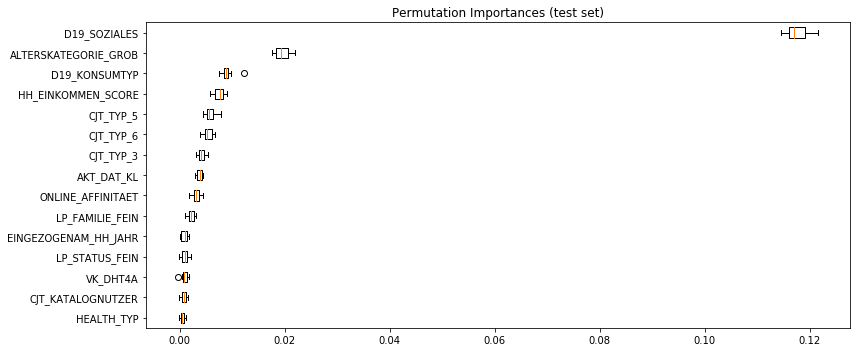

In [28]:
fig, ax = plt.subplots(figsize=(12,5))
ax.boxplot(result.importances[sorted_idx][-15:].T,
           vert=False, labels=X_test_pi.columns[sorted_idx][-15:])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [29]:
pi_variables = X_test_pi.columns[sorted_idx[::-1]][:15].to_list()
pi_variables 

['D19_SOZIALES',
 'ALTERSKATEGORIE_GROB',
 'D19_KONSUMTYP',
 'HH_EINKOMMEN_SCORE',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'CJT_TYP_3',
 'AKT_DAT_KL',
 'ONLINE_AFFINITAET',
 'LP_FAMILIE_FEIN',
 'EINGEZOGENAM_HH_JAHR',
 'LP_STATUS_FEIN',
 'VK_DHT4A',
 'CJT_KATALOGNUTZER',
 'HEALTH_TYP']

## Model explainability

### eli5

In [30]:
X_train_r, X_test_r, y_train_r, y_test_r = split(both_resampled)

In [31]:
numerical_columns_r, categorical_columns_r = var_lists(both_resampled)

In [32]:
rf_r = create_pipe(categorical_columns_r, numerical_columns_r)
rf_r.fit(X_train_r, y_train_r)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [33]:
X_train_tr = rf_r['preprocess'].fit_transform(X_train_r)
X_test_tr = rf_r['preprocess'].fit_transform(X_test_r)

In [34]:
feats = get_feats(rf_r, categorical_columns_r, numerical_columns_r)

In [35]:
X_train_tr.shape, X_test_tr.shape

((22500, 363), (7500, 363))

In [36]:
rf_r2 = create_num_pipe(numerical_columns_r)
rf_r2.fit(X_train_tr, y_train_r)

Pipeline(memory=None,
         steps=[('preprocess',
                 Pipeline(memory=None,
                          steps=[('imputer',
                                  SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                missing_values=nan,
                                                strategy='median',
                                                verbose=0))],
                          verbose=False)),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
           

In [37]:
%%time

perm = PermutationImportance(rf_r2, random_state=SEED).fit(X_test_tr, y_test_r)

CPU times: user 4min 54s, sys: 3.31 s, total: 4min 57s
Wall time: 4min 57s


In [38]:
eli5.show_weights(perm, feature_names = feats)

Weight,Feature
0.0594 ± 0.0018,D19_SOZIALES
0.0277 ± 0.0023,ALTERSKATEGORIE_GROB
0.0202 ± 0.0034,D19_KONSUMTYP
0.0068 ± 0.0024,CJT_TYP_3
0.0054 ± 0.0018,CJT_TYP_6
0.0037 ± 0.0026,RT_SCHNAEPPCHEN
0.0018 ± 0.0024,CJT_TYP_5
0.0007 ± 0.0012,FINANZ_MINIMALIST
0.0007 ± 0.0013,AKT_DAT_KL
0.0006 ± 0.0004,D19_RATGEBER


Important variables: D19_SOZIALES, ALTERSKATEGORIE_GROB, D19_KONSUMTYP

#### Select variables

In [39]:
%%time
# perm.feature_importances_ attribute is now available, it can be used
# for feature selection - let's e.g. select features which increase
# accuracy by at least threshold:
sel = SelectFromModel(perm, threshold=0.003, prefit=True)
X_train_reduced = sel.transform(X_train_tr)
X_test_reduced = sel.transform(X_test_tr)

CPU times: user 9.77 ms, sys: 1.92 ms, total: 11.7 ms
Wall time: 9.7 ms


In [40]:
X_test_reduced.shape, X_test_tr.shape

((7500, 6), (7500, 363))

In [41]:
most_important_variables = np.array(feats)[sel.get_support()].tolist()
most_important_variables

['ALTERSKATEGORIE_GROB',
 'RT_SCHNAEPPCHEN',
 'CJT_TYP_6',
 'D19_SOZIALES',
 'CJT_TYP_3',
 'D19_KONSUMTYP']

In [42]:
len(most_important_variables)

6

### Shap

In [43]:
rf_model = RandomForestClassifier(random_state=SEED)

X_train_tr = pd.DataFrame(rf_r['preprocess'].fit_transform(X_train_r), columns = feats)
X_test_tr = pd.DataFrame(rf_r['preprocess'].fit_transform(X_test_r), columns = feats)

rf_model.fit(X_train_tr, y_train_r)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [44]:
explainer = shap.TreeExplainer(rf_model)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [45]:
%%time
# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_test_tr, check_additivity=False)

CPU times: user 21min 58s, sys: 3.48 s, total: 22min 2s
Wall time: 22min


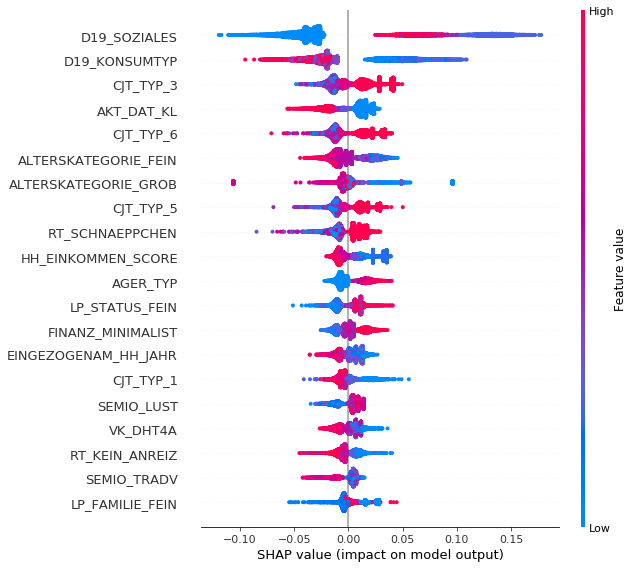

In [46]:
# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test_tr)

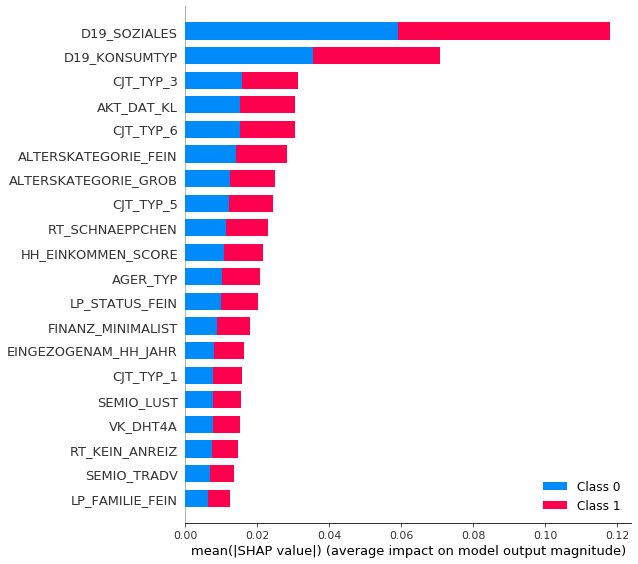

In [47]:
shap.summary_plot(shap_values, X_test_tr, plot_type='bar')

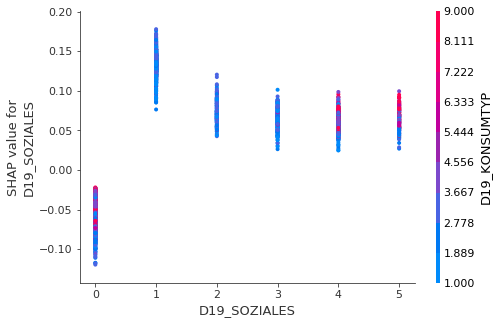

In [48]:
# make plot.
shap.dependence_plot('D19_SOZIALES', shap_values[1], X_test_tr, interaction_index="D19_KONSUMTYP")

## Variable reduction effect in model's performance

In [49]:
test_vars = rf_importances_df[:10].features.tolist()
test_vars

['D19_SOZIALES',
 'D19_KONSUMTYP',
 'ALTERSKATEGORIE_GROB',
 'CJT_TYP_6',
 'CJT_TYP_3',
 'CJT_TYP_5',
 'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'RT_SCHNAEPPCHEN',
 'EINGEZOGENAM_HH_JAHR']

In [50]:
%%time

test_performance(both_resampled, most_important_variables)
print()

Pipeline completed. Model ROC-AUC: 0.793.
Model with 6 variables succesfully trained. Final ROC-AUC: 0.823

CPU times: user 9.65 s, sys: 440 ms, total: 10.1 s
Wall time: 10.1 s


In [51]:
%%time

results = []
for i in range(10,200,10):
    print()
    print(i)
    test_vars = rf_importances_df[:i].features.tolist() # take the first i variables
    result = test_performance(both_resampled,  test_vars)
    print(result)
    results.append(result)

print()


10
Pipeline completed. Model ROC-AUC: 0.793.
Model with 10 variables succesfully trained. Final ROC-AUC: 0.820
0.8195846125299951

20
Pipeline completed. Model ROC-AUC: 0.793.
Model with 20 variables succesfully trained. Final ROC-AUC: 0.828
0.8277223513465476

30
Pipeline completed. Model ROC-AUC: 0.793.
Model with 30 variables succesfully trained. Final ROC-AUC: 0.828
0.8277415148879373

40
Pipeline completed. Model ROC-AUC: 0.793.
Model with 40 variables succesfully trained. Final ROC-AUC: 0.827
0.8266520539365592

50
Pipeline completed. Model ROC-AUC: 0.793.
Model with 50 variables succesfully trained. Final ROC-AUC: 0.827
0.82742213766852

60
Pipeline completed. Model ROC-AUC: 0.793.
Model with 60 variables succesfully trained. Final ROC-AUC: 0.829
0.8287803877229453

70
Pipeline completed. Model ROC-AUC: 0.793.
Model with 70 variables succesfully trained. Final ROC-AUC: 0.824
0.8243548357652715

80
Pipeline completed. Model ROC-AUC: 0.793.
Model with 80 variables succesfully tra

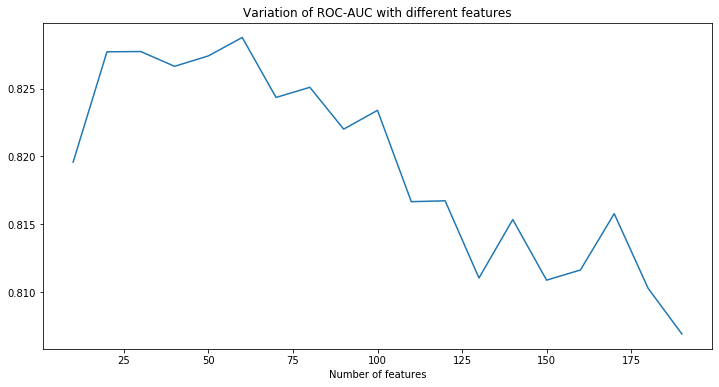

In [52]:
plt.figure(figsize=(12,6))
plt.plot(range(10,200,10), results)
plt.xlabel('Number of features')
plt.ylabel('')
plt.title('Variation of ROC-AUC with different features')
plt.show()

The optimal number of features to take from RF is around 20. Let's save those features for later use.

In [53]:
best_features_RF = rf_importances_df[:20].features.tolist()
best_features_RF

['D19_SOZIALES',
 'D19_KONSUMTYP',
 'ALTERSKATEGORIE_GROB',
 'CJT_TYP_6',
 'CJT_TYP_3',
 'CJT_TYP_5',
 'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'RT_SCHNAEPPCHEN',
 'EINGEZOGENAM_HH_JAHR',
 'FINANZ_MINIMALIST',
 'LP_FAMILIE_FEIN',
 'LP_STATUS_FEIN',
 'CJT_TYP_1',
 'RT_KEIN_ANREIZ',
 'SEMIO_LUST',
 'HH_EINKOMMEN_SCORE',
 'AGER_TYP',
 'VK_DHT4A',
 'CJT_GESAMTTYP']

Test with `pi_variables`

In [54]:
test_performance(both_resampled,  most_important_variables)

Pipeline completed. Model ROC-AUC: 0.793.
Model with 6 variables succesfully trained. Final ROC-AUC: 0.823


0.8225780757642871

Test with the whole dataset and `best_features_RF`

In [55]:
%%time 

test_performance(both, best_features_RF)

Pipeline completed. Model ROC-AUC: 0.809.
Model with 20 variables succesfully trained. Final ROC-AUC: 0.831
CPU times: user 2min 12s, sys: 4.77 s, total: 2min 17s
Wall time: 2min 18s


0.8308147183148128

## Save the datasets

Save as a dict with the most important variables from each method

{data: 'azdias.clean', most_important_RF: , permutation_importance: ,

In [56]:
clean_data_dict = {'azdias_data': azdias_clean, 'customers_data': customers_clean, 'RF_vars': best_features_RF,
                  'eli5_vars': most_important_variables}


In [58]:
save_dict(clean_data_dict,'clean_data_dict')

In [65]:
# test the process went OK
clean_data_dict_loaded = load_dict('clean_data_dict')
clean_data_dict_loaded

data/clean_data_dict.pickle


{'azdias_data':         D19_LOTTO  D19_VOLLSORTIMENT  KBA13_TOYOTA  KBA05_CCM4  \
 LNR                                                              
 910241        0.0                  0           3.0         2.0   
 645153        6.0                  0           3.0         4.0   
 612565        NaN                  0           NaN         NaN   
 612592        NaN                  0           2.0         4.0   
 703164        NaN                  0           NaN         NaN   
 ...           ...                ...           ...         ...   
 814493        NaN                  0           3.0         4.0   
 814552        7.0                  0           3.0         1.0   
 825726        7.0                  0           1.0         0.0   
 825745        0.0                  0           2.0         4.0   
 825776        0.0                  0           2.0         1.0   
 
         KBA13_HERST_FORD_OPEL  RELAT_AB  UMFELD_ALT  WOHNDAUER_2008  \
 LNR                                    

In [66]:
type(clean_data_dict_loaded)

dict